In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from segment_anything import sam_model_registry, SamPredictor

def load_image(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def apply_white_background(image, mask):
    white_bg = np.ones_like(image) * 255
    return np.where(mask[..., None], image, white_bg)

def count_yellow_pixels(image, mask):
    masked = image.copy()
    masked[~mask] = 0
    hsv = cv2.cvtColor(masked, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return yellow_mask.sum()

def process_image(image, predictor):
    h, w = image.shape[:2]
    prompts = [
        [w // 2, h // 2], [w // 4, h // 4], [3 * w // 4, h // 4],
        [w // 4, 3 * h // 4], [3 * w // 4, 3 * h // 4]
    ]

    best_score = -1
    best_mask = None

    predictor.set_image(image)
    for prompt in prompts:
        input_point = np.array([prompt])
        input_label = np.array([1])
        masks, scores, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True
        )

        for mask in masks:
            score = count_yellow_pixels(image, mask)
            if score > best_score:
                best_score = score
                best_mask = mask

    return apply_white_background(image, best_mask) if best_mask is not None else image

def batch_process(input_folder, output_folder, checkpoint="sam_vit_b_01ec64.pth", model_type="vit_b"):
    os.makedirs(output_folder, exist_ok=True)
    sam = sam_model_registry[model_type](checkpoint=checkpoint).to("cuda")
    predictor = SamPredictor(sam)

    img_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for fname in tqdm(img_files, desc="Processing"):
        in_path = os.path.join(input_folder, fname)
        out_path = os.path.join(output_folder, fname)

        try:
            image = load_image(in_path)
            masked_img = process_image(image, predictor)
            Image.fromarray(masked_img).save(out_path)
        except Exception as e:
            print(f"Failed on {fname}: {e}")

# 示例调用
input_dir = "./images/SalamanderID2025/database/images/"
output_dir = "./images/SalamanderID2025/database/images_masked/"
batch_process(input_dir, output_dir)

Processing: 8fc01bc3445e3558_1174.jpg


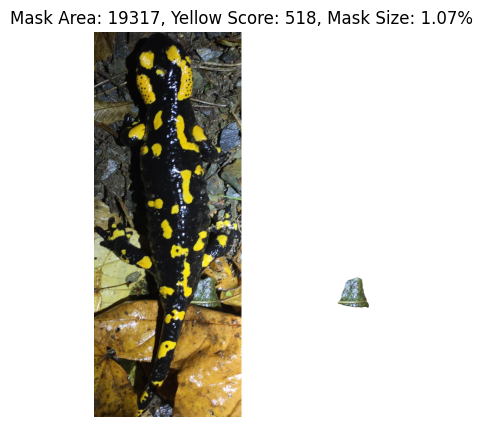

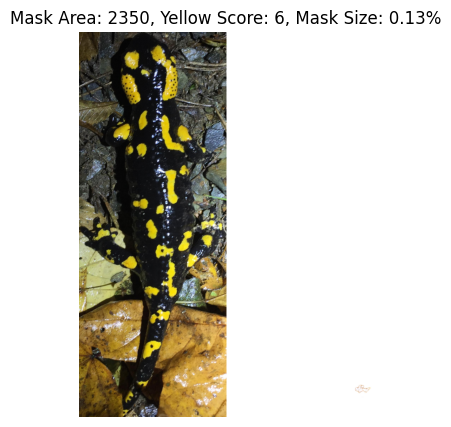

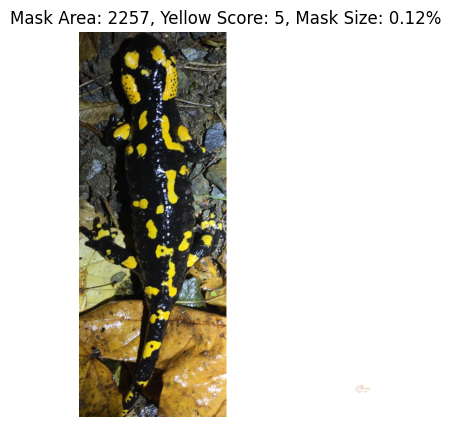

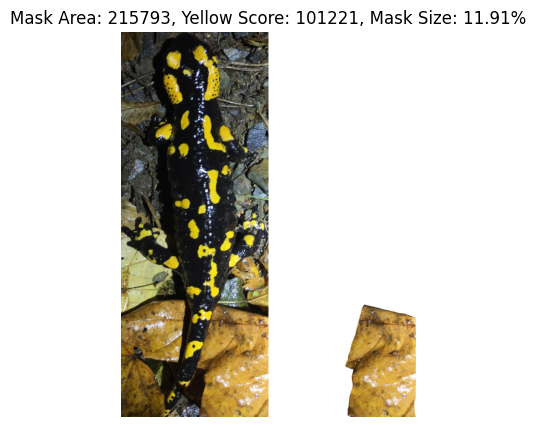

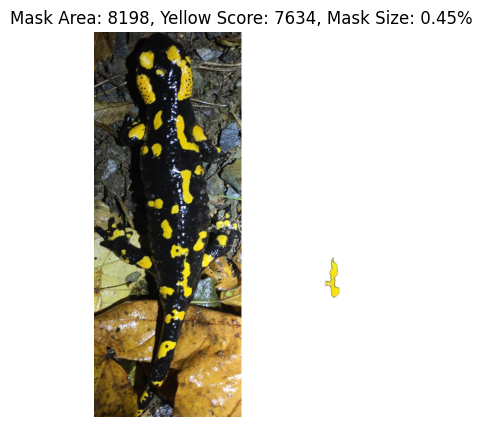

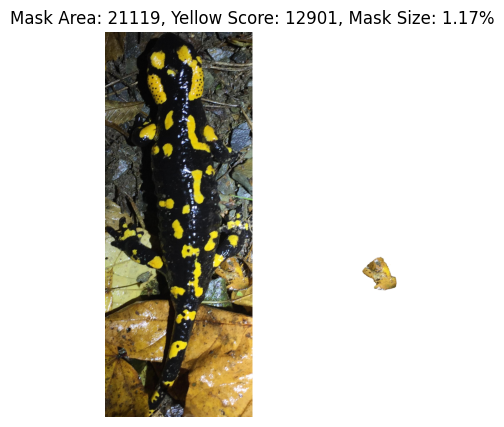

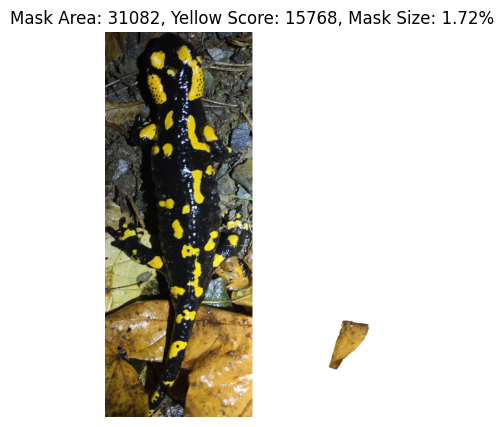

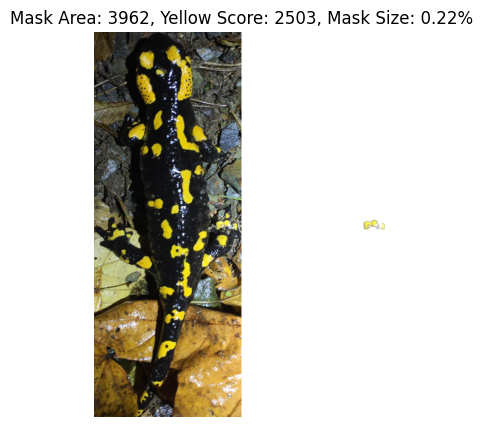

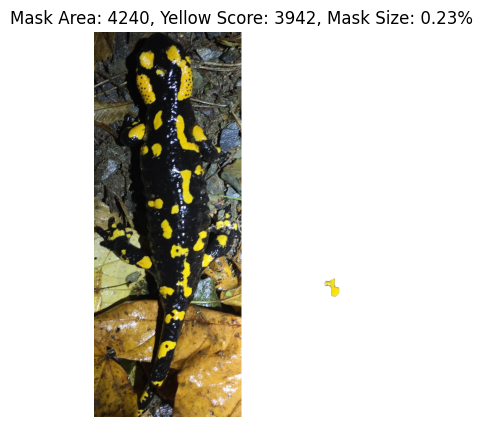

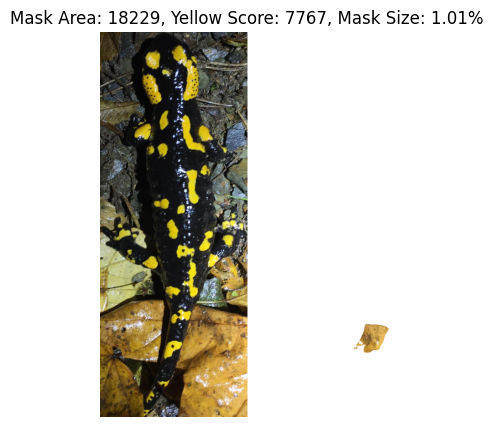

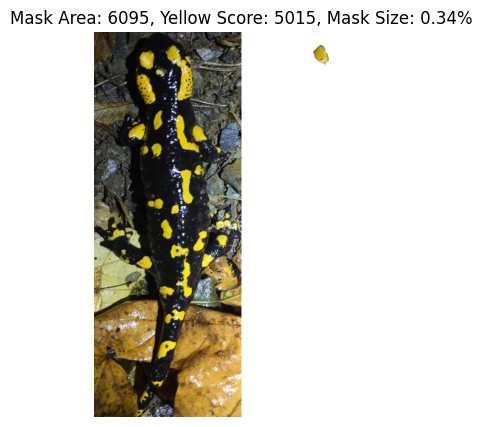

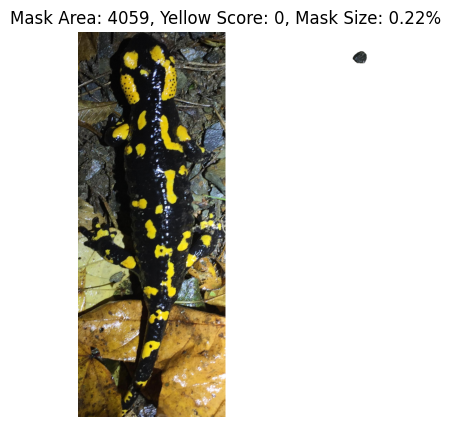

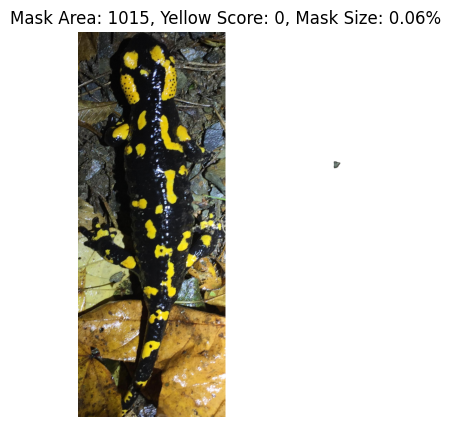

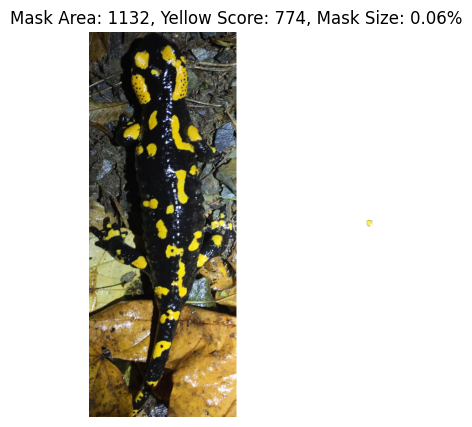

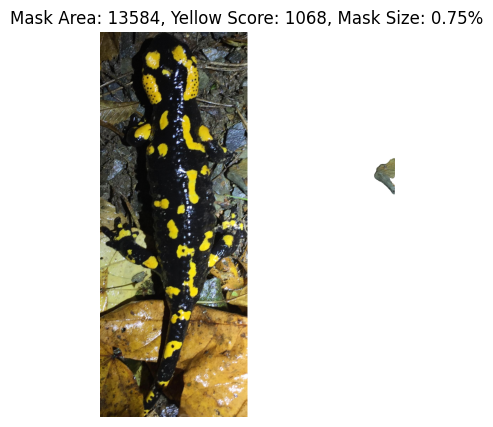

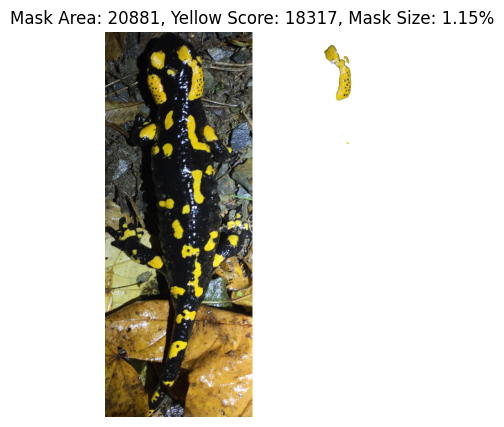

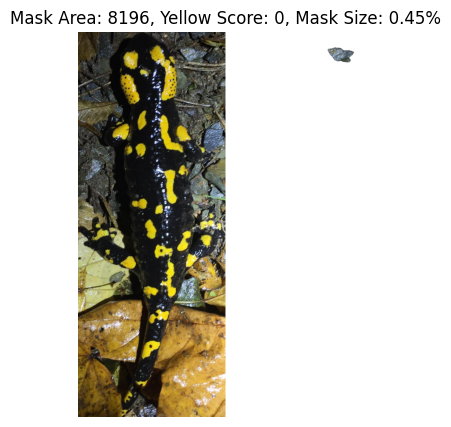

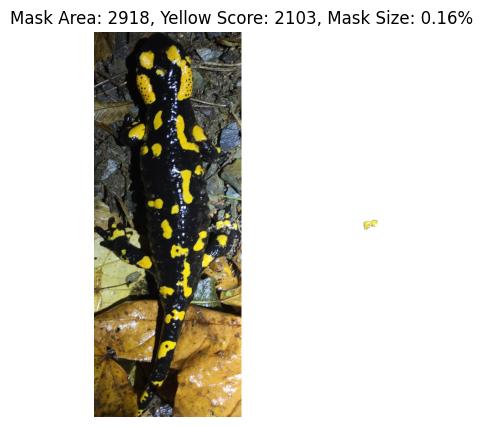

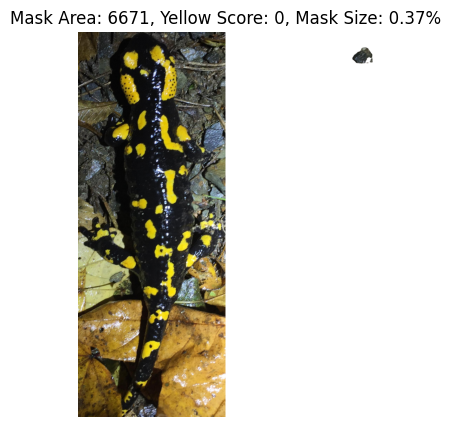

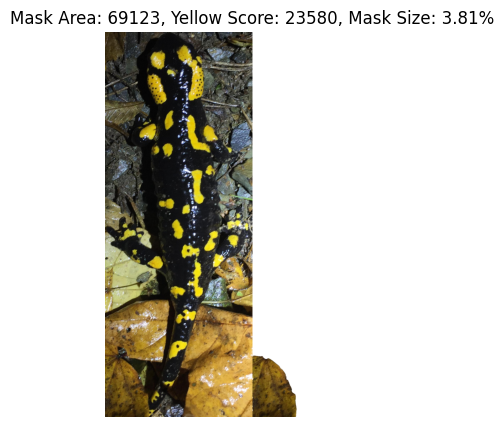

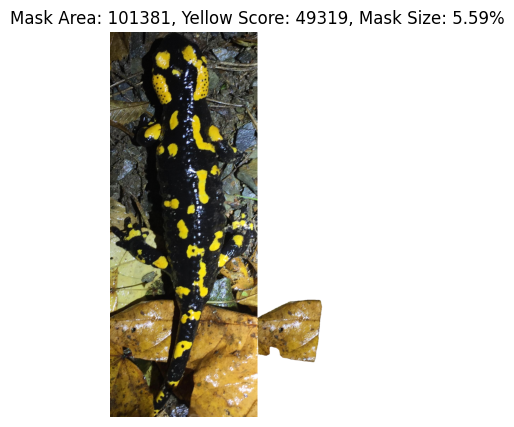

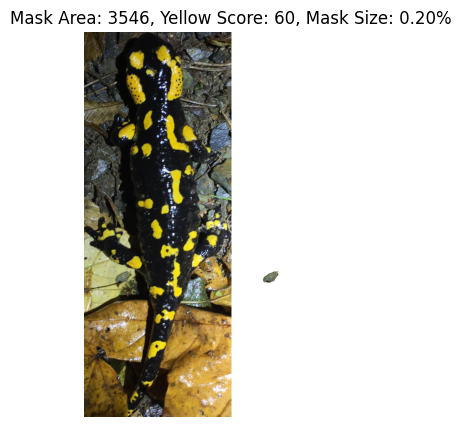

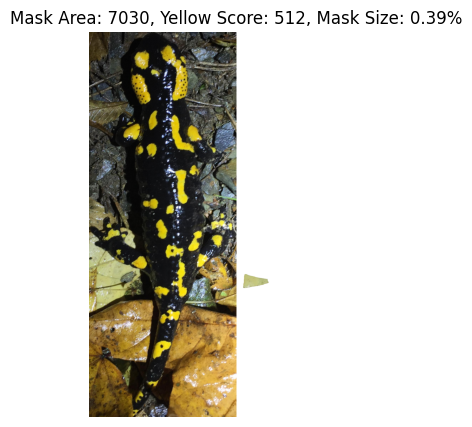

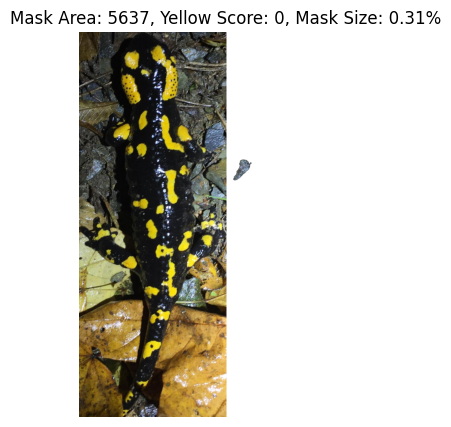

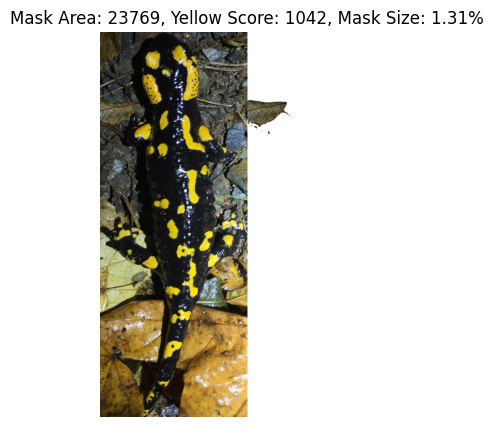

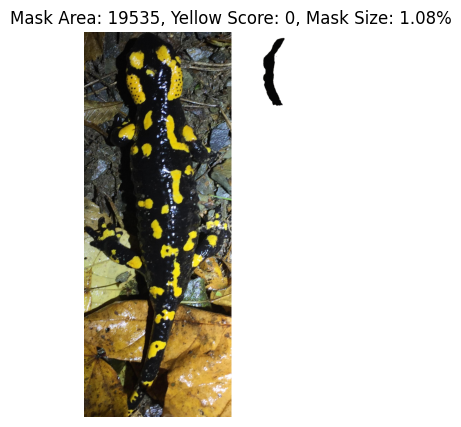

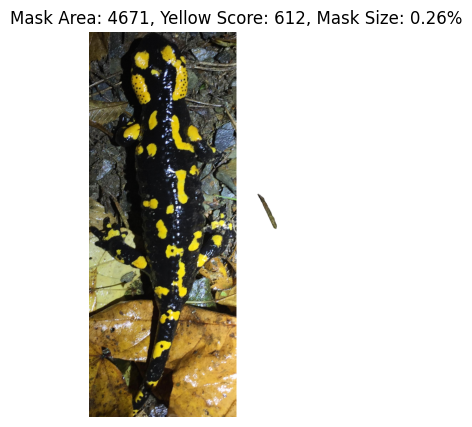

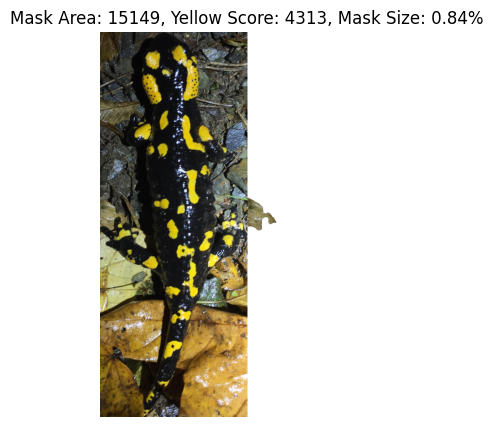

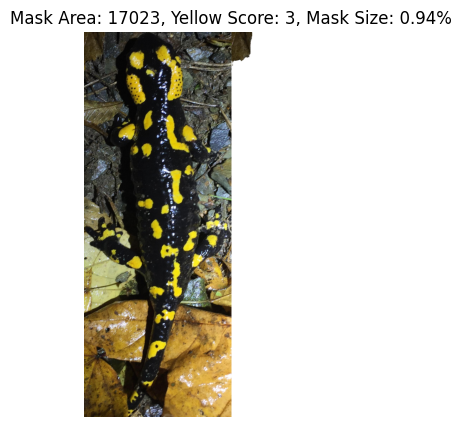

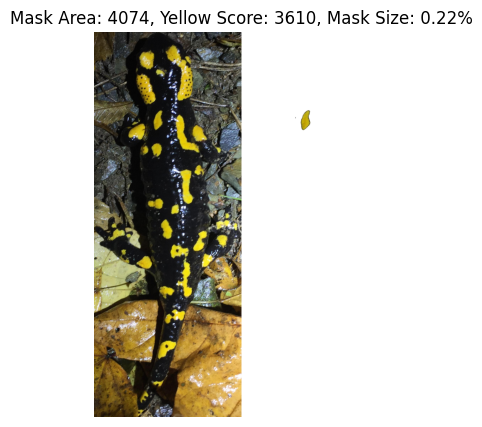

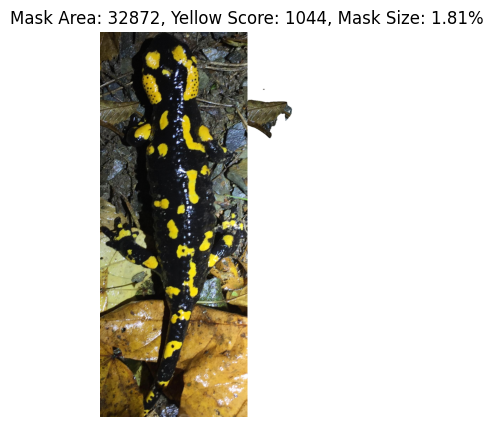

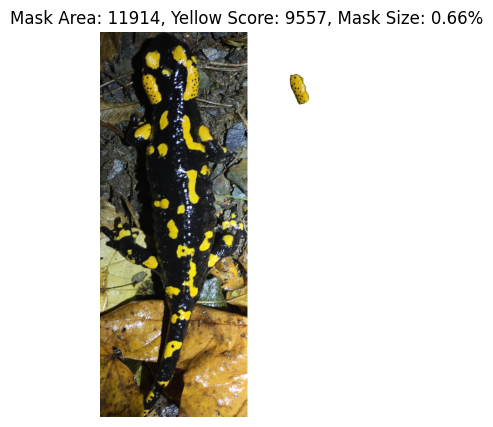

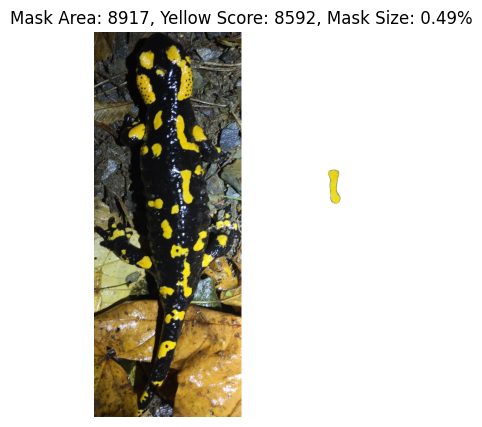

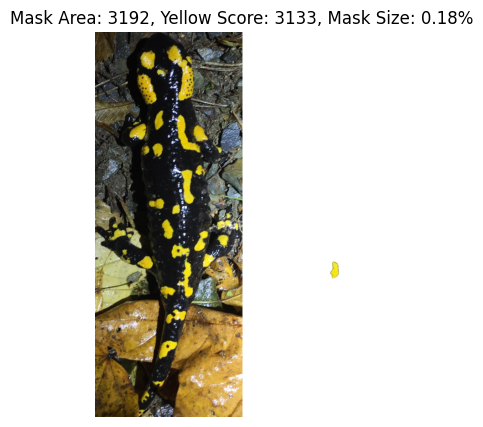

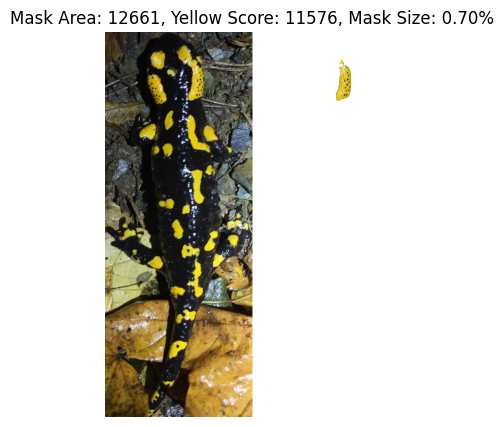

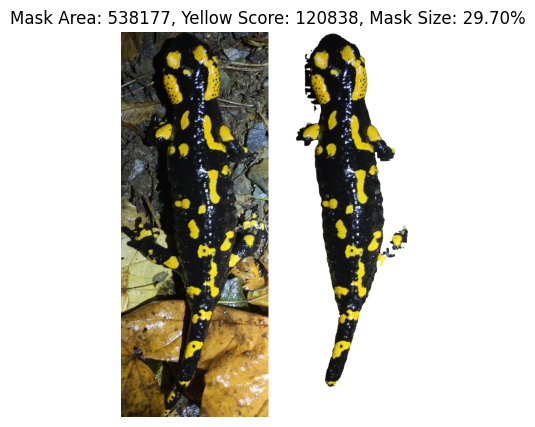

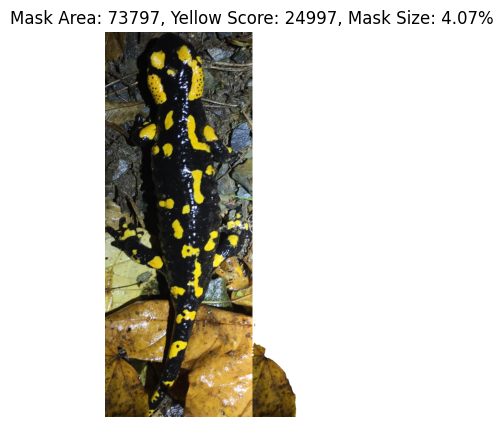

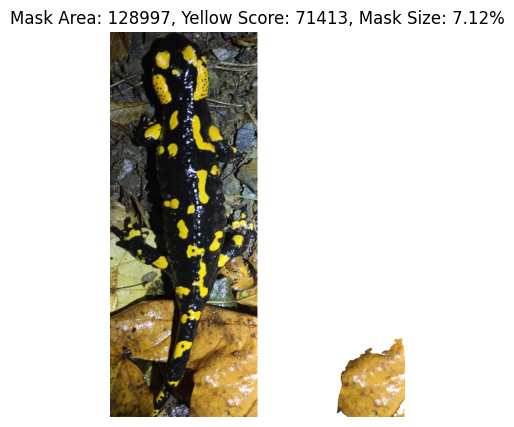

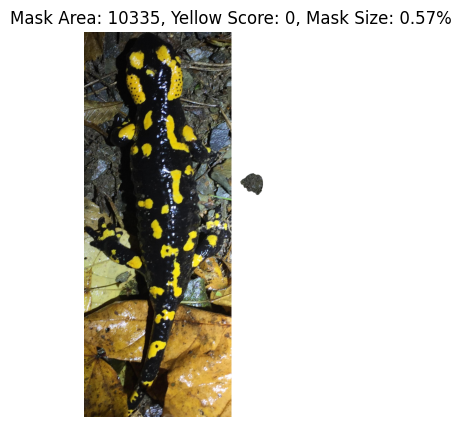

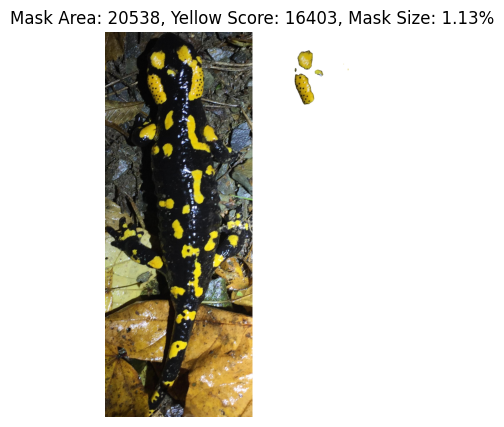

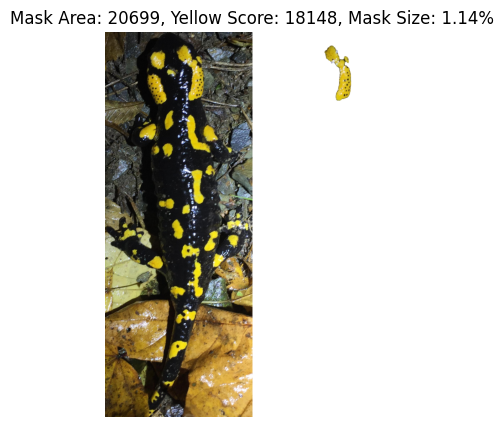

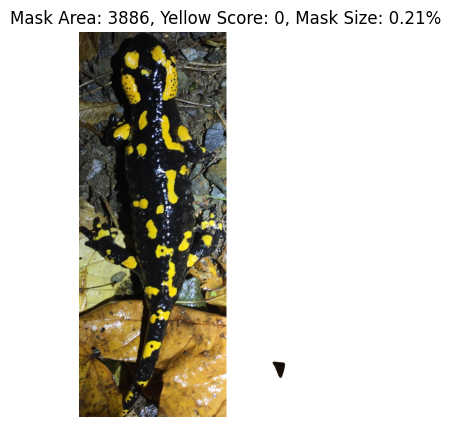

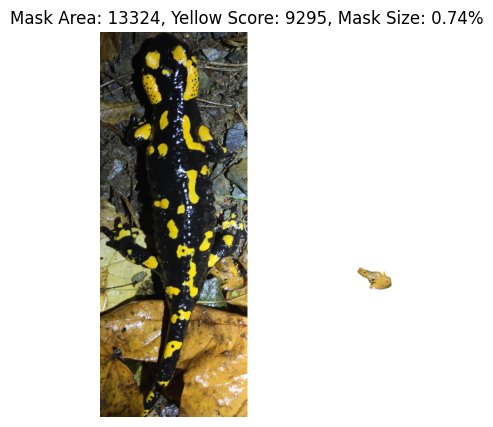

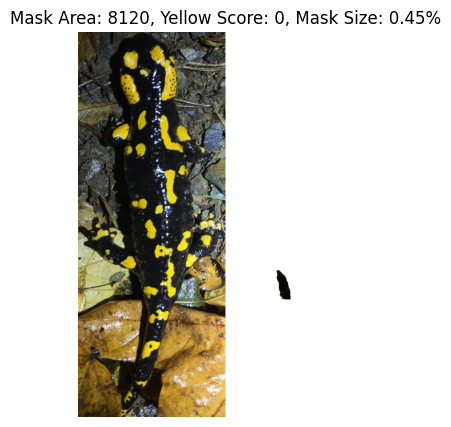

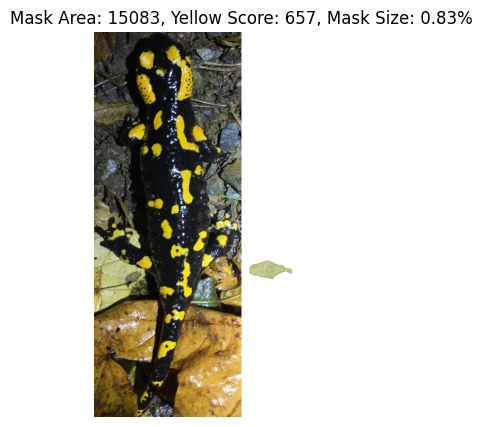

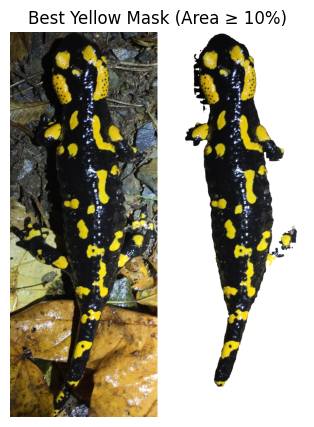

In [12]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- 设置图片目录 ---
folder_path = "./images/SalamanderID2025/database/images"

# 随机选择一张图片
def get_random_image_path(folder, exts={'.jpg', '.jpeg', '.png'}):
    files = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]
    return os.path.join(folder, random.choice(files))

# 加载图像
def load_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 黄色色素评分
def count_yellow_pixels(image, mask):
    masked = image.copy()
    masked[~mask] = 0
    hsv = cv2.cvtColor(masked, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, (20, 100, 100), (40, 255, 255))
    return np.count_nonzero(yellow_mask)

# 白背景替换
def apply_white_background(image, mask):
    white_bg = np.ones_like(image) * 255
    return np.where(mask[..., None], image, white_bg)

# 展示
def plot_result(original, masked, title=""):
    plt.figure(figsize=(10, 5))
    plt.imshow(np.hstack([original, masked]))
    plt.axis("off")
    plt.title(title)
    plt.show()

# --- 主流程 ---
def run_one_random_image():
    image_path = get_random_image_path(folder_path)
    image = load_image(image_path)
    print(f"Processing: {os.path.basename(image_path)}")

    H, W = image.shape[:2]
    min_area = 0.10 * (H * W)

    # 初始化 SAM
    sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth").to("cuda")
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=4,
        pred_iou_thresh=0.8,
        stability_score_thresh=0.85,
        crop_n_layers=1,
    )

    masks = mask_generator.generate(image)

    best_score = -1
    best_mask = None
    for m in masks:
        mask = m["segmentation"]
        area = mask.sum()
        # if area < min_area:
        #     continue  # 跳过太小的主体
        yellow_score = count_yellow_pixels(image, mask)

        tmp = apply_white_background(image, mask)
        plot_result(image, tmp, title=f"Mask Area: {area}, Yellow Score: {yellow_score}, Mask Size: {area/(H*W):.2%}")

        
        if yellow_score > best_score:
            best_score = yellow_score
            best_mask = mask
        

    if best_mask is not None:
        result = apply_white_background(image, best_mask)
        plot_result(image, result, title="Best Yellow Mask (Area ≥ 10%)")
    else:
        print("No suitable mask found (area too small or no yellow region).")

# --- 执行 ---
run_one_random_image()